# Telecom Churn Prediction
The solution code is divided into the following sections: 
* Data understanding
* Preprocessing
* EDA
* Handle missing values
* Feature Engineering
* Model 1 - Customer Churn Prediction
    * Feature Selection and Dimensionality Reduction using PCA
    * Handling Class Imbalance using ADASYN
    * Baseline Model building
    * Cross validation
    * Hyperparameter tuning 
    * Model Evaluation
    * Model Selection
* Model 2 - Identifying Strong Predictors of churn (Important features)
    * Feature Selection using ExtraTreesClassifier
    * Handling Class Imbalance using ADASYN
    * Model building
    * Hyperparameter tuning with Cross Validation
    * Model Evaluation
    
* Strategy recommendation to manage customer churn

# Load libraries

* Let us start with loading the required libraries. 
* Also initialise the RANDOM_STATE global constant to use in the following sections. 

In [2]:
!pip install imblearn

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.decomposition import PCA

%matplotlib inline
RANDOM_STATE = 42

# Data Understanding

* Load the dataset(telecom_churn_data.csv) file from the data folder. 
* Once we read the data in, print the first 5 lines of the DataFrame.

In [4]:
data = pd.read_csv('telecom_churn_data.csv',error_bad_lines=False)
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


We can start to see some useful patterns in the dataset.

* mobile_number is the unique_id column for each customer.
* columns are segregated by months of jun(6), jul(7), aug(8), sep(9) for the year 2014.

Let's check for the count of rows and columns in the given dataset

In [5]:
data.shape

(99999, 226)

It has about a lack of customer records and 226 columns in it.

Now we will see the types of the columns in the dataset.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


It has 214 numeric and 12 non-numeric columns in the dataset

# Data Preprocessing

#### Helper functions for the data preprocessing

In [7]:
'''
Method Name : get_cols_split
Input(s)    : 1 DataFrame
Output(s)   : 6 lists  
Description :
- This method reads the columns in the given dataframe and splits them into various categories such as months, date related cols 
  and other common cols  
- Then returns the column lists as output for each of these categories. 
'''
def get_cols_split(df):

    col_len = len(df.columns)

    jun_cols = []
    jul_cols = []
    aug_cols = []
    sep_cols = []
    common_cols = []
    date_cols = []
    
    for i in range(0, col_len):
        if any(pd.Series(df.columns[i]).str.contains('_6|jun')):
            jun_cols.append(df.columns[i])
        elif any(pd.Series(df.columns[i]).str.contains('_7|jul')):
            jul_cols.append(df.columns[i])
        elif any(pd.Series(df.columns[i]).str.contains('_8|aug')):
            aug_cols.append(df.columns[i])
        elif any(pd.Series(df.columns[i]).str.contains('_9|sep')):
            sep_cols.append(df.columns[i])
        else:
            common_cols.append(df.columns[i])
        
        if any(pd.Series(df.columns[i]).str.contains('date')):
            date_cols.append(df.columns[i])
            
    return jun_cols,jul_cols,aug_cols,sep_cols,common_cols,date_cols

In [8]:
'''
Method Name : get_cols_sub_split
Input(s)    : 1 list
Output(s)   : 4 lists  
Description :
- This method gets the columns list as input and splits them into various sub-categories such as call_usage, recharge columns, 
  incoming and outgoing related cols  
- Then returns the column lists as output for each of these sub-categories. 
'''
def get_cols_sub_split(col_list):
    call_usage_cols = []
    recharge_cols = []
    ic_usage_cols = []
    og_usage_cols = []

    call_usage_search_for = ['og','ic','mou']

    for i in range(0, len(col_list)):
        if any(pd.Series(col_list[i]).str.contains('|'.join(['rech','rch']))):
            recharge_cols.append(col_list[i])
        elif any(pd.Series(col_list[i]).str.contains('|'.join(call_usage_search_for))):
            call_usage_cols.append(col_list[i])

        if any(pd.Series(col_list[i]).str.contains('ic')):
            ic_usage_cols.append(col_list[i])
        elif any(pd.Series(col_list[i]).str.contains('og')):
            og_usage_cols.append(col_list[i])
            
    return call_usage_cols,recharge_cols,ic_usage_cols,og_usage_cols            

### Classify the churn and non-churn customers

Now tag the churned customers as 1 else 0 based on the Sep month and derive the Churn(Response) column for the given dataset.

In [9]:
# mark the rows as churn if the sum of the total mou and vol of 9 month is 0
tag_churn_cols = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
data['churn'] = np.where(data[tag_churn_cols].sum(axis=1) == 0, 1, 0 )

To tag the churned customers,
* Take the columns such as 'total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9'
* Find the sum of above columns values for each records
* Tag the customer record as Churned(1) if the sum value is 0 else Non-Churned(0) and derive the Churn column

Now check for the count of churned customers in the obtained dataset.

In [10]:
data['churn'].value_counts()

0    89808
1    10191
Name: churn, dtype: int64

From around 30000 customer records, we have about more than 2500 churned customers. 

The churn rate would be as follows:

In [11]:
print('Churn Rate : {0}%'.format(round(((sum(data['churn'])/len(data['churn']))*100),2)))

Churn Rate : 10.19%


Churn rate is less than 10% of the overall data available. This indicates that we would need to handle the class imbalance in this classification problem.

#### Remove Sep month columns

Now we can go ahead and remove the Sep(9) month columns as we would not need it further

In [12]:
# Get the columns split by months
jun_cols, jul_cols, aug_cols, sep_cols, common_cols, date_cols = get_cols_split(data)

In [13]:
# Drop all the sep columns
data.drop(sep_cols, axis=1, inplace=True)

#### Check for the unwanted columns and remove

Now we can check for the less info columns or sparsed columns and remove them if not required.

In [14]:
# Get the unique count
print(data.nunique())

mobile_number     99999
circle_id             1
loc_og_t2o_mou        1
std_og_t2o_mou        1
loc_ic_t2o_mou        1
                  ...  
aon                3489
aug_vbc_3g        14676
jul_vbc_3g        14162
jun_vbc_3g        13312
churn                 2
Length: 172, dtype: int64


In [15]:
data[['mobile_number','circle_id','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',\
           'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',\
           'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8']].head(5)

,mobile_number,circle_id,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
0,7000842753,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0
1,7001865778,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7001625959,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7001204172,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7000142493,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It seems, we can very well remove the above listed columns from the dataset.

In [16]:
# Remove unwanted columns
data.drop(['mobile_number','circle_id','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',\
           'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',\
           'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8'], axis=1, inplace=True)

Now let's check for the recharge columns value.

In [17]:
data[['total_rech_data_6','av_rech_amt_data_6','max_rech_data_6']].head()

,total_rech_data_6,av_rech_amt_data_6,max_rech_data_6
0,1.0,252.0,252.0
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,1.0,56.0,56.0


Found that the average recharge amount for data columns actually depicts the total amount rather than average value. So we will rename the columns to proper name.

In [18]:
#Rename the cols to correct name
data = data.rename(columns={'av_rech_amt_data_6':'total_rech_amt_data_6','av_rech_amt_data_7':'total_rech_amt_data_7','av_rech_amt_data_8':'total_rech_amt_data_8'})

# Handling Missing Values

Next, we will check for the count of missing values in the dataset and list the columns with the missing values.

In [19]:
df = data.isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt
114,count_rech_2g_6,74846
108,total_rech_data_6,74846
120,total_rech_amt_data_6,74846
129,arpu_3g_6,74846
111,max_rech_data_6,74846
...,...,...
67,std_ic_t2t_mou_7,3859
40,std_og_mou_7,3859
101,date_of_last_rech_8,3622
100,date_of_last_rech_7,1767


Now we will pass the dataframe to **get_cols_split** helper function and get the column categories.

In [20]:
# Get the columns split to months
jun_cols, jul_cols, aug_cols, sep_cols, common_cols, date_cols = get_cols_split(data)

Similarly, we will pass the month's column list to **get_cols_sub_split** helper function and get the columns sub-categories.

In [21]:
# Get the columns sub split for each months
jun_call_usage_cols, jun_recharge_cols, jun_ic_usage_cols, jun_og_usage_cols = get_cols_sub_split(jun_cols)
jul_call_usage_cols, jul_recharge_cols, jul_ic_usage_cols, jul_og_usage_cols = get_cols_sub_split(jul_cols)
aug_call_usage_cols, aug_recharge_cols, aug_ic_usage_cols, aug_og_usage_cols = get_cols_sub_split(aug_cols)

There are few missing values which we will start filling in one by one. 

fb_user and night_pack_user columns are of nominal type 0 and 1. Since missing values could be of another type, imputing them as 2.

In [22]:
# Filling the missing values of fb and night pack user columns as 2, as this could be an another type that was marked as NA
cols_6 = ['fb_user_6','night_pck_user_6']
cols_7 = ['fb_user_7','night_pck_user_7']
cols_8 = ['fb_user_8','night_pck_user_8']

data[cols_6] = data[cols_6].fillna(2)
data[cols_7] = data[cols_7].fillna(2)
data[cols_8] = data[cols_8].fillna(2)

The missing values for the below set of columns seem to be as data not available. So imputing them with 0.

In [23]:
# filling the missing values as 0
cols_6 = ['count_rech_3g_6','max_rech_data_6','total_rech_amt_data_6','arpu_3g_6','total_rech_data_6','count_rech_2g_6','arpu_2g_6']
cols_7 = ['count_rech_3g_7','max_rech_data_7','total_rech_amt_data_7','arpu_3g_7','total_rech_data_7','count_rech_2g_7','arpu_2g_7']
cols_8 = ['count_rech_3g_8','max_rech_data_8','total_rech_amt_data_8','arpu_3g_8','total_rech_data_8','count_rech_2g_8','arpu_2g_8']

data[cols_6] = data[cols_6].fillna(0)
data[cols_7] = data[cols_7].fillna(0)
data[cols_8] = data[cols_8].fillna(0)

In [24]:
# filling the missing values as 0 for month columns
data[jun_call_usage_cols] = data[jun_call_usage_cols].fillna(0)
data[jul_call_usage_cols] = data[jul_call_usage_cols].fillna(0)
data[aug_call_usage_cols] = data[aug_call_usage_cols].fillna(0)

Now let's check for the missing values count again.

In [25]:
# Leaving date cols as null intentionally for feature engineering
df = data.isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt
105,date_of_last_rech_data_6,74846
106,date_of_last_rech_data_7,74428
107,date_of_last_rech_data_8,73660
101,date_of_last_rech_8,3622
100,date_of_last_rech_7,1767
99,date_of_last_rech_6,1607


Few date columns have some missing values. But let's leave that as is for now and will use that later point in time.

# EDA

#### Churn (Target Variable)

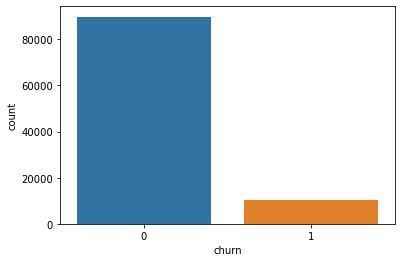

In [26]:
sns.countplot(x='churn', data=data)

As we observed earlier, churn rate is low in the overall dataset. So we would need to handle the class imbalance.

#### Age on Network (aon)

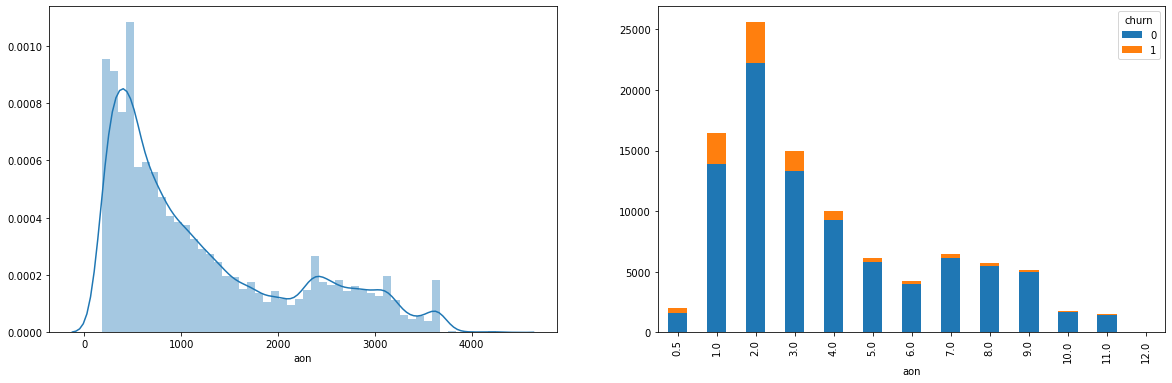

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 6))

# distribution plot for aon
sns.distplot(data['aon'], ax=ax1)

# bin the aon column with yearwise segments and plot the counts for each segments
bins = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#sns.countplot(pd.cut(round(((data['aon']/30)/12),1), bins = bins, labels = labels ), ax =ax1)
pd.crosstab(pd.cut(round(((data['aon']/30)/12),1), bins = bins, labels = labels ), data['churn']).plot(kind='bar', stacked=True, ax = ax2)

* We could see more number of observations between 1 and 3 years.
* Also churn rate is high during this range than the others.

#### Incoming Calls Usage

,loc_ic_mou_6,std_ic_mou_6,isd_ic_mou_6,roam_ic_mou_6,spl_ic_mou_6,ic_others_6,total_ic_mou_6
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,160.896870,31.179327,7.166881,9.558277,0.059133,0.821007,200.130037
std,251.192138,104.361211,58.553452,71.403643,0.158174,11.718638,291.651671
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.680000,0.000000,0.000000,0.000000,0.000000,0.000000,38.530000
50%,86.040000,5.010000,0.000000,0.000000,0.000000,0.000000,114.740000
75%,200.580000,25.410000,0.000000,0.000000,0.000000,0.000000,251.670000
max,7454.630000,5712.110000,6789.410000,13724.380000,19.760000,1362.940000,7716.140000


,loc_ic_mou_7,std_ic_mou_7,isd_ic_mou_7,roam_ic_mou_7,spl_ic_mou_7,ic_others_7,total_ic_mou_7
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,161.247178,32.580088,8.013288,6.873981,0.032289,0.973870,202.853055
std,253.318185,111.695196,63.969156,72.029965,0.152828,12.427693,298.124954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.710000,0.000000,0.000000,0.000000,0.000000,0.000000,41.190000
50%,86.610000,5.060000,0.000000,0.000000,0.000000,0.000000,116.340000
75%,198.690000,26.640000,0.000000,0.000000,0.000000,0.000000,250.660000
max,9669.910000,6745.760000,5289.540000,15371.040000,21.330000,1495.940000,9699.010000


,loc_ic_mou_8,std_ic_mou_8,isd_ic_mou_8,roam_ic_mou_8,spl_ic_mou_8,ic_others_8,total_ic_mou_8
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,158.427961,31.371656,7.987986,6.900761,0.038191,0.918590,198.750783
std,246.124674,107.385484,62.102622,66.558003,0.142454,12.924043,289.321094
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.590000,0.000000,0.000000,0.000000,0.000000,0.000000,38.290000
50%,84.990000,4.690000,0.000000,0.000000,0.000000,0.000000,114.660000
75%,197.540000,25.510000,0.000000,0.000000,0.000000,0.000000,248.990000
max,10830.160000,5957.140000,4127.010000,13095.360000,16.860000,2327.510000,10830.380000


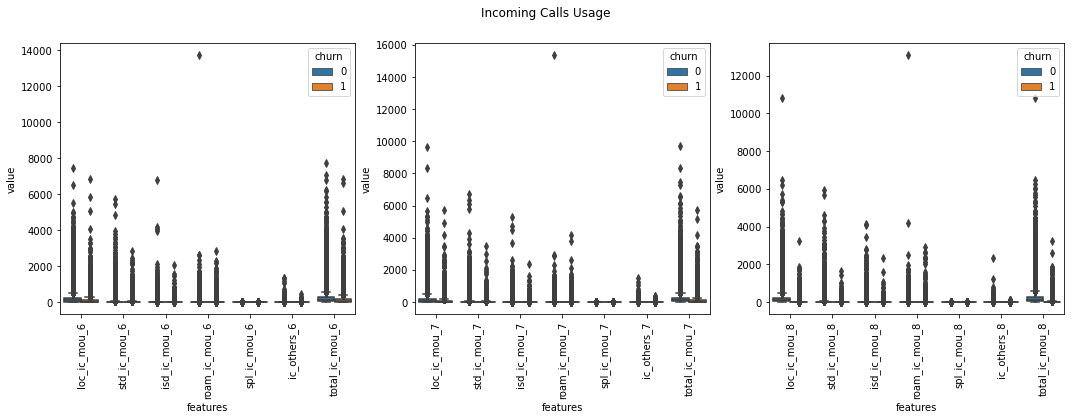

In [28]:
cols = [['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6','roam_ic_mou_6','spl_ic_mou_6','ic_others_6','total_ic_mou_6'],
        ['loc_ic_mou_7','std_ic_mou_7','isd_ic_mou_7','roam_ic_mou_7','spl_ic_mou_7','ic_others_7','total_ic_mou_7'],
        ['loc_ic_mou_8','std_ic_mou_8','isd_ic_mou_8','roam_ic_mou_8','spl_ic_mou_8','ic_others_8','total_ic_mou_8']]

# column description stats
for i in range(0,3):
    display(data[cols[i]].describe())

# plot for the incoming calls usage
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Incoming Calls Usage')

Almost all the Incoming calls usage columns seem to have outliers at the top percentile.

#### Outgoing Calls Usage

,loc_og_mou_6,std_og_mou_6,isd_og_mou_6,roam_og_mou_6,spl_og_mou_6,og_others_6,total_og_mou_6
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,138.523918,161.636708,0.766849,13.363643,3.762604,0.436277,305.133424
std,248.334416,383.593393,25.253433,70.074931,14.659270,4.044839,463.419481
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.930000,0.000000,0.000000,0.000000,0.000000,0.000000,44.740000
50%,59.910000,9.180000,0.000000,0.000000,0.000000,0.000000,145.140000
75%,161.920000,132.490000,0.000000,0.000000,2.180000,0.000000,372.860000
max,10643.380000,8432.990000,5900.660000,3775.110000,1023.210000,800.890000,10674.030000


,loc_og_mou_7,std_og_mou_7,isd_og_mou_7,roam_og_mou_7,spl_og_mou_7,og_others_7,total_og_mou_7
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,136.203358,168.459573,0.746604,9.439823,4.786165,0.029069,310.231175
std,245.406396,402.372971,25.104616,57.347933,20.281655,2.119603,480.031178
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.480000,0.000000,0.000000,0.000000,0.000000,0.000000,43.010000
50%,58.860000,8.610000,0.000000,0.000000,0.000000,0.000000,141.530000
75%,157.970000,136.900000,0.000000,0.000000,3.380000,0.000000,378.570000
max,7674.780000,10936.730000,5490.280000,2812.040000,2372.510000,370.130000,11365.310000


,loc_og_mou_8,std_og_mou_8,isd_og_mou_8,roam_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,133.727502,164.823386,0.748693,9.435597,4.781974,0.031577,304.119513
std,241.325369,402.334570,24.848715,62.989180,17.405718,2.260134,478.150031
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.410000,0.000000,0.000000,0.000000,0.000000,0.000000,38.580000
50%,56.840000,7.250000,0.000000,0.000000,0.000000,0.000000,138.610000
75%,156.985000,129.415000,0.000000,0.000000,3.540000,0.000000,369.900000
max,11039.910000,13980.060000,5681.540000,5337.040000,1390.880000,394.930000,14043.060000


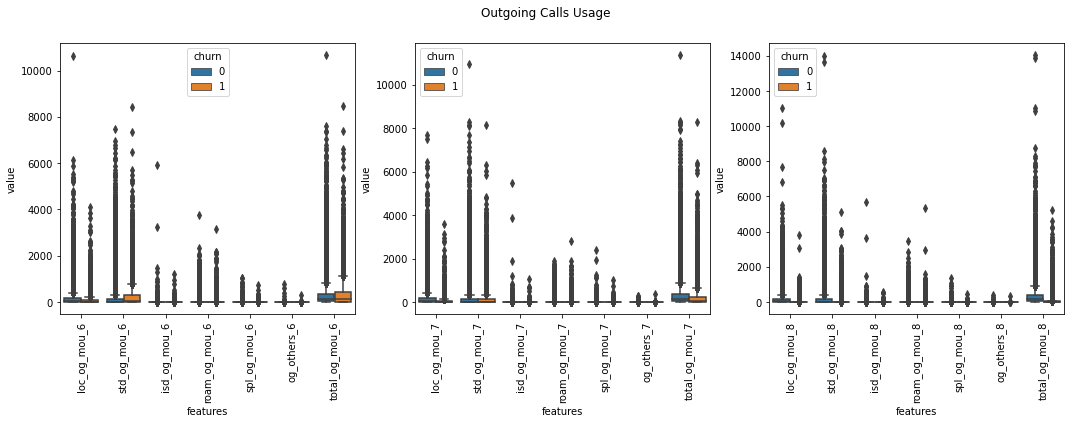

In [29]:
cols = [['loc_og_mou_6','std_og_mou_6','isd_og_mou_6','roam_og_mou_6','spl_og_mou_6','og_others_6','total_og_mou_6'],
        ['loc_og_mou_7','std_og_mou_7','isd_og_mou_7','roam_og_mou_7','spl_og_mou_7','og_others_7','total_og_mou_7'],
        ['loc_og_mou_8','std_og_mou_8','isd_og_mou_8','roam_og_mou_8','spl_og_mou_8','og_others_8','total_og_mou_8']]

# column description stats
for i in range(0,3):
    display(data[cols[i]].describe())

# plot for the outgoing calls usage
plt.figure(figsize=(18, 5))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outgoing Calls Usage')

Outgoing calls usage columns also seem to have outliers at the top percentile.

#### Operatorwise Calls Usage

,onnet_mou_6,offnet_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,127.183397,190.142776,46.035643,103.244291,11.608541,9.198983,19.906397,2.071499
std,292.433718,312.928229,137.785270,169.592626,39.412899,53.282903,79.289474,16.173049
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.430000,28.760000,2.060000,13.810000,0.000000,0.000000,0.000000,0.000000
50%,30.980000,89.680000,14.190000,52.360000,0.680000,0.000000,1.590000,0.000000
75%,112.610000,222.535000,44.690000,127.600000,7.530000,3.630000,13.980000,0.000000
max,7376.710000,8362.360000,6626.930000,4693.860000,1872.340000,5459.560000,5647.160000,1351.110000


,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,45.246387,89.667174,3.603334,1.078841,76.686937,83.862603,1.084561
std,148.140370,160.573349,13.966557,5.345068,247.943052,251.109975,7.829284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.990000,7.290000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.680000,37.690000,0.000000,0.000000,0.000000,2.890000,0.000000
75%,38.820000,105.780000,1.860000,0.000000,26.910000,48.790000,0.000000
max,6431.330000,4729.740000,1466.030000,342.860000,7366.580000,8314.760000,628.560000


,onnet_mou_7,offnet_mou_7,loc_ic_t2t_mou_7,loc_ic_t2m_mou_7,loc_ic_t2f_mou_7,std_ic_t2t_mou_7,std_ic_t2m_mou_7,std_ic_t2f_mou_7
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,128.512397,189.441086,46.138548,102.986672,12.113470,9.625541,20.820685,2.131371
std,303.869995,321.759659,143.252760,167.398842,42.209845,56.326309,84.937998,16.139100
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.880000,26.650000,2.310000,14.990000,0.000000,0.000000,0.000000,0.000000
50%,29.230000,85.440000,14.330000,53.280000,0.730000,0.000000,1.600000,0.000000
75%,108.880000,217.830000,43.880000,126.680000,7.660000,3.780000,14.740000,0.000000
max,8157.780000,9667.130000,9324.660000,4455.830000,1983.010000,5800.930000,6141.880000,1136.080000


,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,std_og_t2t_mou_7,std_og_t2m_mou_7,std_og_t2f_mou_7
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,44.679599,87.870081,3.646613,1.315689,80.085034,87.299970,1.071982
std,152.555137,155.423787,14.006097,7.391356,258.991617,264.678142,8.434579
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,7.490000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.430000,37.230000,0.000000,0.000000,0.000000,2.580000,0.000000
75%,37.890000,103.360000,1.890000,0.000000,27.255000,49.330000,0.000000
max,7400.660000,4557.140000,1196.430000,916.240000,8133.660000,9284.740000,544.630000


,onnet_mou_8,offnet_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,125.864313,186.002904,44.672310,102.627450,11.119814,9.352359,20.043967,1.972872
std,302.023240,321.325854,133.922257,166.899871,38.150956,53.618152,81.542312,15.388684
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.090000,23.840000,2.000000,13.810000,0.000000,0.000000,0.000000,0.000000
50%,28.040000,83.130000,14.010000,52.680000,0.660000,0.000000,1.430000,0.000000
75%,106.740000,215.500000,43.540000,127.200000,7.260000,3.440000,13.960000,0.000000
max,10752.560000,14007.340000,10696.230000,6274.190000,2433.060000,4309.290000,5645.860000,1394.890000


,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,43.419935,86.820488,3.480186,1.356709,78.803686,85.006833,1.010365
std,147.427075,153.669894,12.935836,6.606329,258.930848,265.124794,7.694209
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.760000,6.310000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.030000,35.890000,0.000000,0.000000,0.000000,2.030000,0.000000
75%,37.360000,102.960000,1.780000,0.000000,25.040000,45.980000,0.000000
max,10752.560000,4961.330000,928.490000,502.090000,8014.430000,13950.040000,516.910000


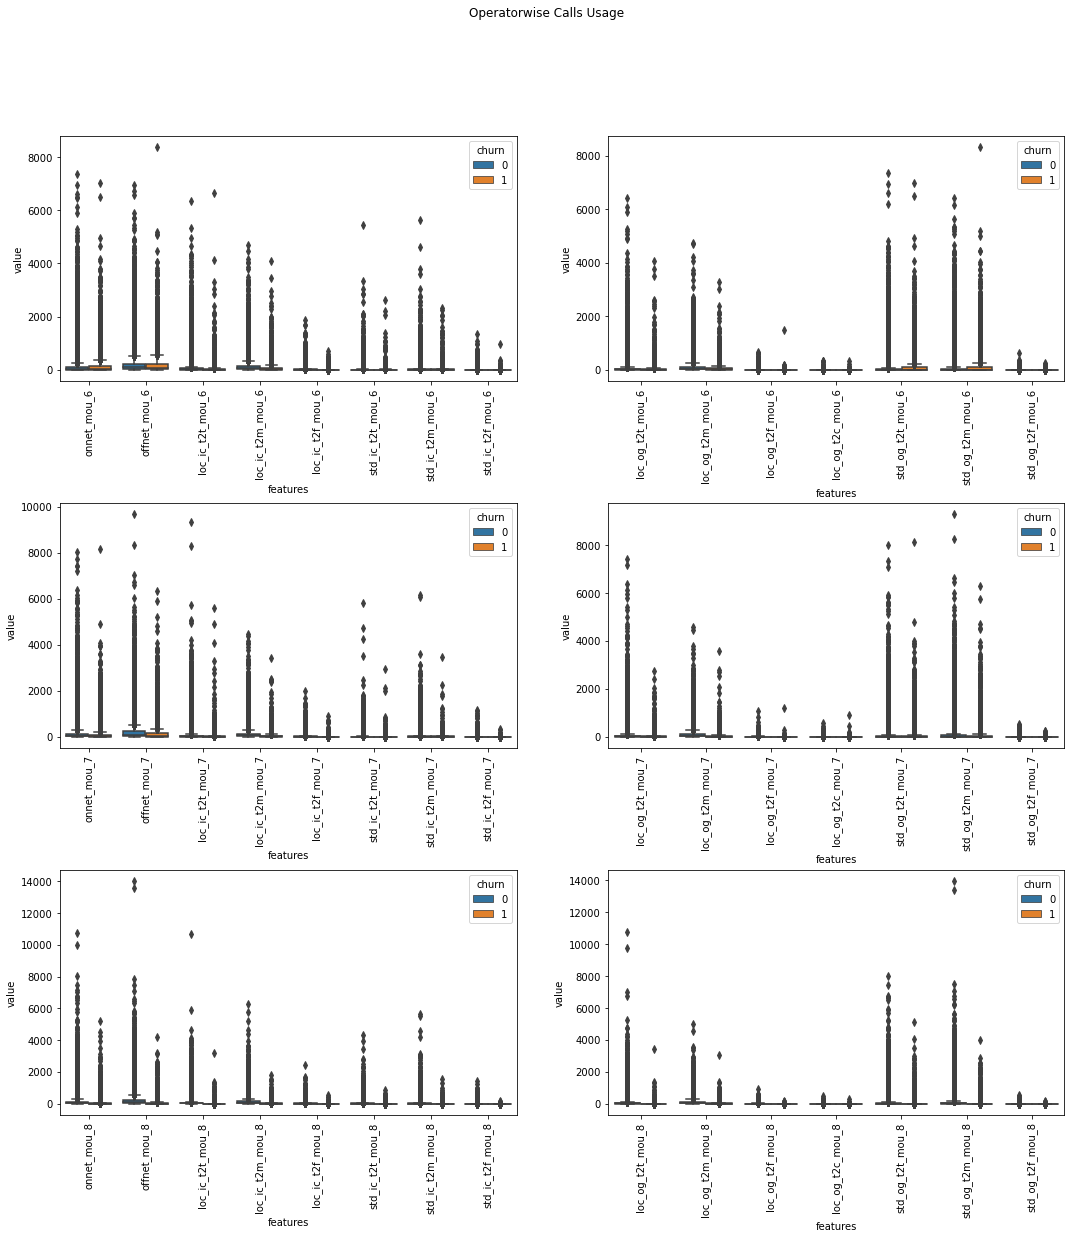

In [30]:
cols = [['onnet_mou_6','offnet_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6'],
        ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6'],
        ['onnet_mou_7','offnet_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7'],
        ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7'],
        ['onnet_mou_8','offnet_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8'],
        ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8']]

# column description stats
for i in range(0,6):
    display(data[cols[i]].describe())

# plot for the operatorwise calls usage
plt.figure(figsize=(18, 18))
plt.subplots_adjust(hspace=0.5)
for i in range(0,6):
    plt.subplot(3,2,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Operatorwise Calls Usage')

Operatorwise calls usage columns also seem to have outliers at the top percentile.

#### Recharge Amount

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
count,99999.000000,99999.000000,99999.000000
mean,327.514615,322.962970,324.157122
std,398.019701,408.114237,416.540455
min,0.000000,0.000000,0.000000
25%,109.000000,100.000000,90.000000
50%,230.000000,220.000000,225.000000
75%,437.500000,428.000000,434.500000
max,35190.000000,40335.000000,45320.000000


,total_rech_amt_voice_6,total_rech_amt_voice_7,total_rech_amt_voice_8
count,99999.000000,99999.000000,99999.000000
mean,282.317553,275.251886,275.542894
std,375.373125,382.794116,390.824802
min,0.000000,0.000000,0.000000
25%,60.000000,50.000000,50.000000
50%,190.000000,175.000000,176.000000
75%,380.000000,370.000000,380.000000
max,35190.000000,40335.000000,45320.000000


,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8
count,99999.000000,99999.000000,99999.000000
mean,48.445409,51.393440,52.027022
std,127.743863,132.629365,131.182609
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,8.250000,17.000000,23.000000
max,7546.000000,4365.000000,4076.000000


,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
count,99999.000000,99999.000000,99999.000000
mean,104.637486,104.752398,107.728207
std,120.614894,124.523970,126.902505
min,0.000000,0.000000,0.000000
25%,30.000000,30.000000,30.000000
50%,110.000000,110.000000,98.000000
75%,120.000000,128.000000,144.000000
max,4010.000000,4010.000000,4449.000000


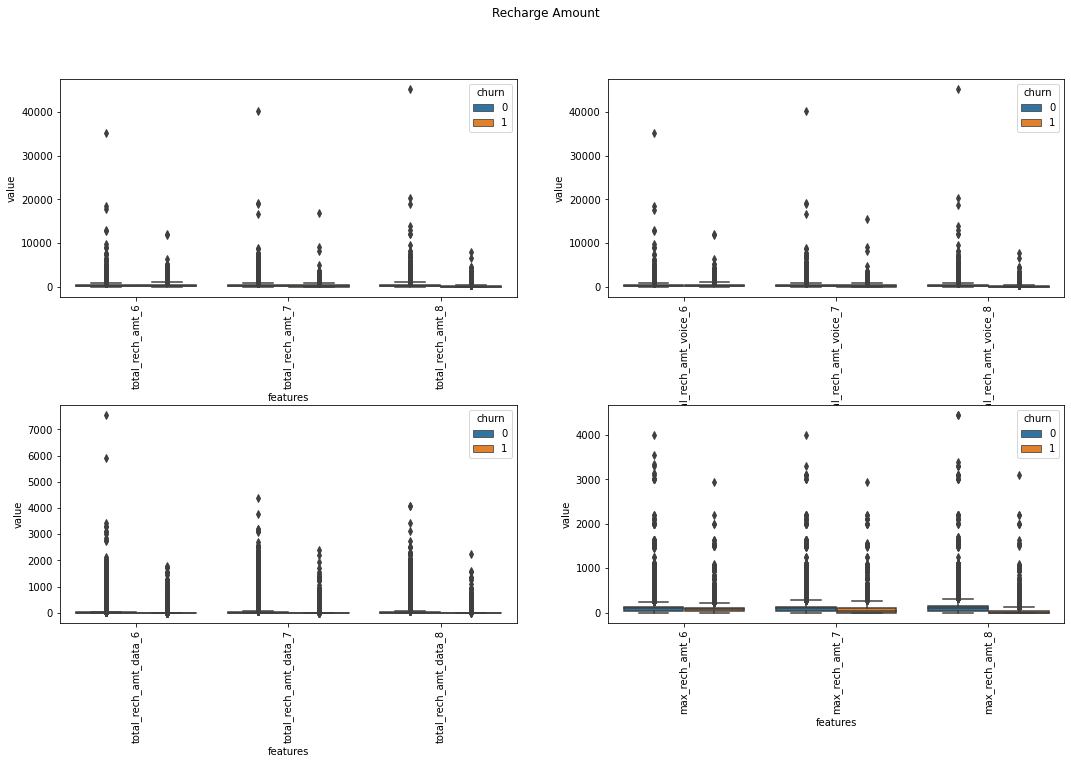

In [31]:
# Let's derive total recharge amount for voice with the diff recharge amount of total and data
data['total_rech_amt_voice_6'] = np.where((data['total_rech_amt_6'] >= data['total_rech_amt_data_6']), (data['total_rech_amt_6'] - data['total_rech_amt_data_6']), 0)
data['total_rech_amt_voice_7'] = np.where((data['total_rech_amt_7'] >= data['total_rech_amt_data_7']), (data['total_rech_amt_7'] - data['total_rech_amt_data_7']), 0)
data['total_rech_amt_voice_8'] = np.where((data['total_rech_amt_8'] >= data['total_rech_amt_data_8']), (data['total_rech_amt_8'] - data['total_rech_amt_data_8']), 0)

cols = [
        ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8'],
        ['total_rech_amt_voice_6','total_rech_amt_voice_7','total_rech_amt_voice_8'],
        ['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8'],
        ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
       ]

# column description stats
for i in range(0,4):
    display(data[cols[i]].describe())

# plot for the recharge amount columns
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(0,4):
    plt.subplot(2,2,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Recharge Amount')

Recharge amount columns also seem to have outliers at the top percentile.

#### Recharge Count

,total_rech_num_6,total_rech_num_7,total_rech_num_8
count,99999.000000,99999.000000,99999.000000
mean,7.558806,7.700367,7.212912
std,7.078405,7.070422,7.203753
min,0.000000,0.000000,0.000000
25%,3.000000,3.000000,3.000000
50%,6.000000,6.000000,5.000000
75%,9.000000,10.000000,9.000000
max,307.000000,138.000000,196.000000


,total_rech_data_6,total_rech_data_7,total_rech_data_8
count,99999.000000,99999.000000,99999.000000
mean,0.619726,0.681837,0.698517
std,1.760541,1.924382,1.963417
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,61.000000,54.000000,60.000000


,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,99999.000000,99999.000000,99999.000000
mean,31.792048,32.406314,33.113011
std,77.248778,78.342435,78.872739
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,8.000000,14.000000,17.000000
max,1555.000000,1555.000000,1555.000000


,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8
count,99999.000000,99999.000000,99999.000000
mean,0.469025,0.522855,0.531075
std,1.521915,1.659925,1.654565
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,42.000000,48.000000,44.000000


,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8
count,99999.000000,99999.000000,99999.000000
mean,0.150702,0.158982,0.167442
std,0.689999,0.755537,0.782059
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,29.000000,35.000000,45.000000


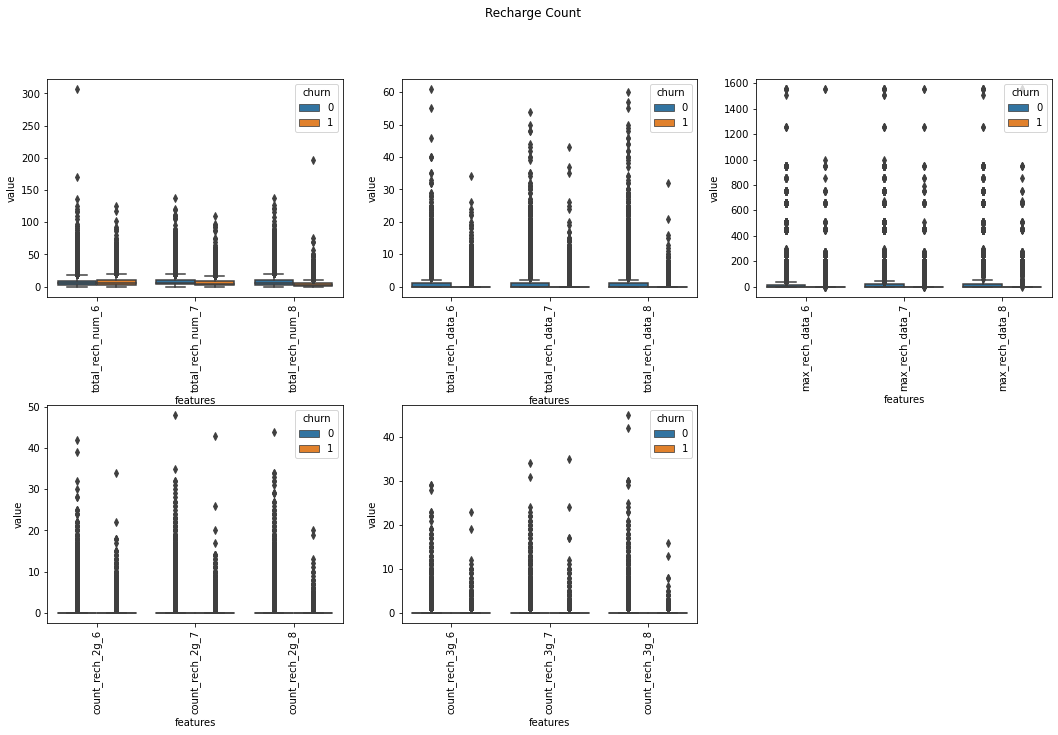

In [32]:
cols = [
        ['total_rech_num_6','total_rech_num_7','total_rech_num_8'],
        ['total_rech_data_6','total_rech_data_7','total_rech_data_8'],
        ['max_rech_data_6','max_rech_data_7','max_rech_data_8'],
        ['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8'],
        ['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'] 
       ]

# column description stats
for i in range(0,5):
    display(data[cols[i]].describe())

# plot for the recharge count columns
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(0,5):
    plt.subplot(2,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Recharge Count')

Recharge count columns also seem to have outliers at the top percentile.

#### Average Revenue per User (Arpu)

,arpu_6,arpu_7,arpu_8
count,99999.000000,99999.000000,99999.000000
mean,282.987358,278.536648,279.154731
std,328.439770,338.156291,344.474791
min,-2258.709000,-2014.045000,-945.808000
25%,93.411500,86.980500,84.126000
50%,197.704000,191.640000,192.080000
75%,371.060000,365.344500,369.370500
max,27731.088000,35145.834000,33543.624000


,arpu_2g_6,arpu_2g_7,arpu_2g_8
count,99999.000000,99999.000000,99999.000000
mean,21.731907,21.969404,22.809665
std,94.408718,96.746052,94.396902
min,-35.830000,-15.480000,-55.830000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,6433.760000,4809.360000,3483.170000


,arpu_3g_6,arpu_3g_7,arpu_3g_8
count,99999.000000,99999.000000,99999.000000
mean,22.526009,22.856642,24.014520
std,104.360309,106.457258,104.593649
min,-30.820000,-26.040000,-24.490000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,6362.280000,4980.900000,3716.900000


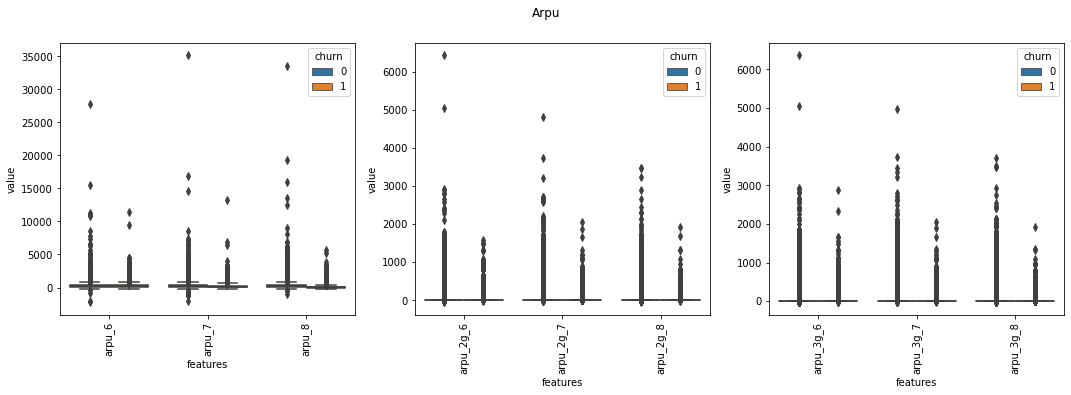

In [33]:
cols = [
        ['arpu_6','arpu_7','arpu_8'],
        ['arpu_2g_6','arpu_2g_7','arpu_2g_8'],
        ['arpu_3g_6','arpu_3g_7','arpu_3g_8']
       ]

# column description stats
for i in range(0,3):
    display(data[cols[i]].describe())

# plot for the arpu
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Arpu')

arpu columns also seem to have outliers at the top percentile.

#### 2G and 3G

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8
count,99999.000000,99999.000000,99999.000000
mean,51.904956,51.229937,50.170154
std,213.356445,212.302217,212.347892
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,10285.900000,7873.550000,11117.610000


,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
count,99999.000000,99999.000000,99999.000000
mean,121.396219,128.995847,135.410689
std,544.247227,541.494013,558.775335
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,45735.400000,28144.120000,30036.060000


,night_pck_user_6,night_pck_user_7,night_pck_user_8
count,99999.000000,99999.000000,99999.000000
mean,1.503245,1.494465,1.478705
std,0.860489,0.865807,0.874848
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000


,fb_user_6,fb_user_7,fb_user_8
count,99999.000000,99999.000000,99999.000000
mean,1.726937,1.720957,1.707847
std,0.491490,0.497836,0.514123
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000


,monthly_2g_6,monthly_2g_7,monthly_2g_8
count,99999.000000,99999.000000,99999.000000
mean,0.079641,0.083221,0.081001
std,0.295058,0.304395,0.299568
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,4.000000,5.000000,5.000000


,monthly_3g_6,monthly_3g_7,monthly_3g_8
count,99999.000000,99999.000000,99999.000000
mean,0.075921,0.078581,0.082941
std,0.363371,0.387231,0.384947
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,14.000000,16.000000,16.000000


,sachet_2g_6,sachet_2g_7,sachet_2g_8
count,99999.000000,99999.000000,99999.000000
mean,0.389384,0.439634,0.450075
std,1.497320,1.636230,1.630263
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,42.000000,48.000000,44.000000


,sachet_3g_6,sachet_3g_7,sachet_3g_8
count,99999.000000,99999.000000,99999.000000
mean,0.074781,0.080401,0.084501
std,0.568344,0.628334,0.660234
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,29.000000,35.000000,41.000000


,jun_vbc_3g,jul_vbc_3g,aug_vbc_3g
count,99999.000000,99999.000000,99999.000000
mean,60.021204,66.839062,68.170248
std,253.938223,271.201856,267.580450
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,11166.210000,9165.600000,12916.220000


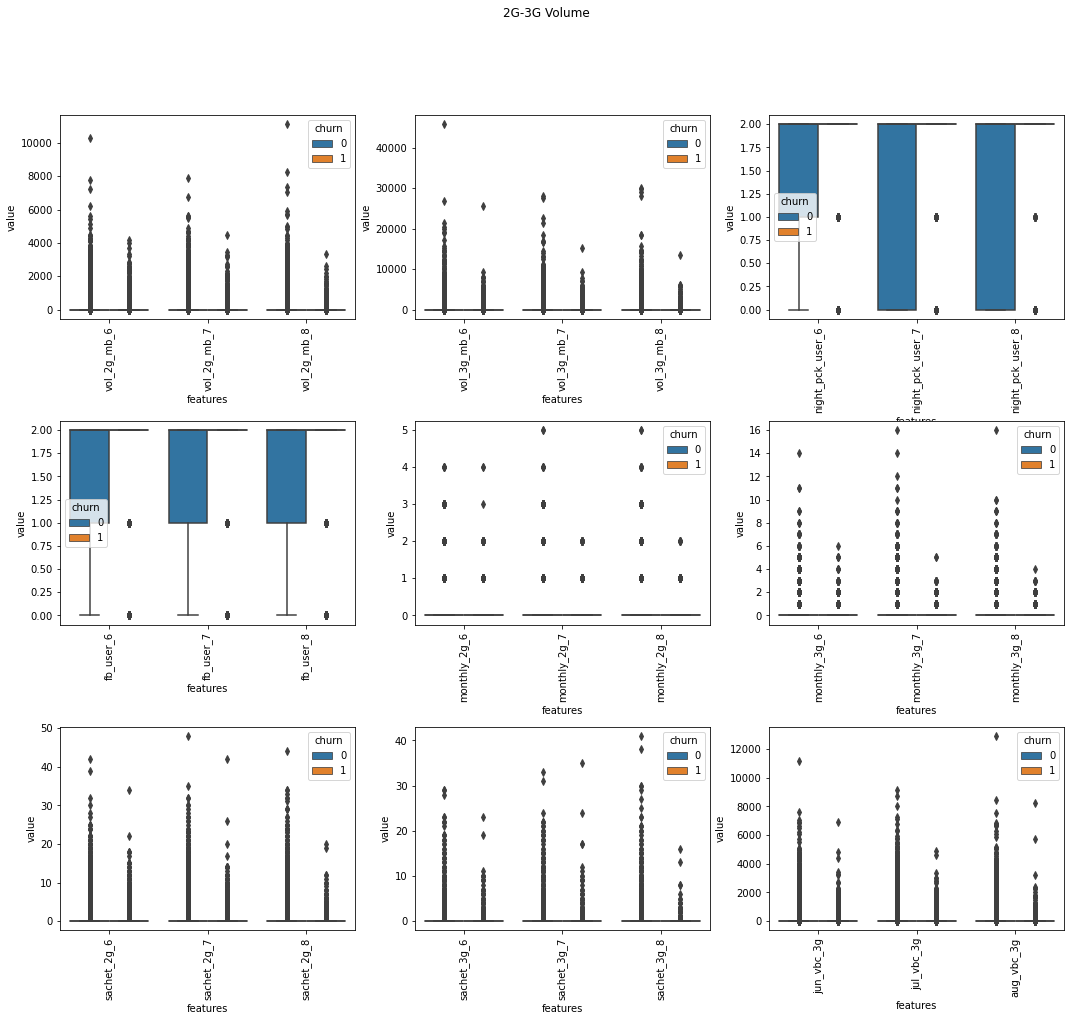

In [34]:
cols = [
        ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'],
        ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],
        ['night_pck_user_6','night_pck_user_7','night_pck_user_8'],
        ['fb_user_6','fb_user_7','fb_user_8'],
        ['monthly_2g_6','monthly_2g_7','monthly_2g_8'],
        ['monthly_3g_6','monthly_3g_7','monthly_3g_8'],
        ['sachet_2g_6','sachet_2g_7','sachet_2g_8'],
        ['sachet_3g_6','sachet_3g_7','sachet_3g_8'],
        ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']
       ]

# column description stats
for i in range(0,9):
    display(data[cols[i]].describe())

# plot for the 2g-3g volume
plt.figure(figsize=(18, 15))
plt.subplots_adjust(hspace=0.5)
for i in range(0,9):
    plt.subplot(3,3,i+1)
    X = pd.concat([data[cols[i]], data['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('2G-3G Volume')

2G and 3G volume columns also seem to have outliers at the top percentile.

# Outliers Treatment

### Cap the outliers at the top percentile

We'll need to cap the outliers at the 99th percentile for the below columns.

In [35]:
cols_to_exclude = ['night_pck_user_6','night_pck_user_7','night_pck_user_8',
                   'fb_user_6','fb_user_7','fb_user_8',
                   'monthly_2g_6','monthly_2g_7','monthly_2g_8',
                   'monthly_3g_6','monthly_3g_7','monthly_3g_8',
                   'sachet_2g_6','sachet_2g_7','sachet_2g_8',
                   'sachet_3g_6','sachet_3g_7','sachet_3g_8',
                   'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8',
                   'spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','spl_og_mou_6','og_others_6','spl_og_mou_7','og_others_7','spl_og_mou_8','og_others_8',
                   'loc_og_t2c_mou_6','std_og_t2f_mou_6','std_ic_t2f_mou_6','loc_ic_t2f_mou_6',
                   'loc_og_t2c_mou_7','std_og_t2f_mou_7','std_ic_t2f_mou_7','loc_ic_t2f_mou_7',
                   'loc_og_t2c_mou_8','std_og_t2f_mou_8','std_ic_t2f_mou_8','loc_ic_t2f_mou_8',
                   'aon','churn'
                  ]
cols = list(set(data.columns).difference(set(cols_to_exclude)))

# iterate through the columns and cap the values with the 99th percentile
for col in cols:
    percentiles = data[col].quantile([0.01,0.99]).values
    #data[col][data[col] <= percentiles[0]] = percentiles[0]
    data[col][data[col] >= percentiles[1]] = percentiles[1]

C:\Users\Dharmil\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Dharmil\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Dharmil\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Dharmil\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning:

### Remove the outliers

We'll need to remove the outliers at the 99th percentile for the below columns.

In [36]:
# remove the outliers with specific columns
data = data.loc[~(
                    ((data['roam_og_mou_8'] > 2200) & (data['churn'] == 1)) |
                    ((data['arpu_7'] > 10000) & (data['churn'] == 1)) |
                    ((data['loc_og_mou_8'] > 2000) & (data['churn'] == 1)) |
                    ((data['loc_ic_mou_7'] > 4000) & (data['churn'] == 1)) |
                    ((data['std_og_mou_7'] > 7000) & (data['churn'] == 1)) |
                    ((data['vol_2g_mb_8'] > 2500) & (data['churn'] == 1)) 
                 )
               ]

# Feature Engineering

### Date columns

Before we extract the date related columns, let's convert the columns to datetime type

In [37]:
# Convert date columns to date format
for col in date_cols:
    data[col] = pd.to_datetime(data[col], format='%m/%d/%Y')

Now, we'll extract the columns from last recharge date and last recharge data date.

In [38]:
cols = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
# get the recent date of recharge in the last 3 months
data['last_rech_date'] = data[cols].max(axis=1)
# get the number of days from the recent recharge date till the last date of august month
data['days_since_last_rech'] = np.floor(( pd.to_datetime('2014-08-31', format='%Y-%m-%d') - data['last_rech_date'] ).astype('timedelta64[D]'))
# fill the null values as 0
data['days_since_last_rech'] = data['days_since_last_rech'].fillna(0)

# subtract it from 3 to add higher weightage for values present in all the columns. 
# len(cols) = 3,  means present in all columns, 0 means not present in any column
data['rech_weightage'] = len(cols) - (data[cols].isnull().sum(axis=1))
data.drop(['last_rech_date','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1, inplace=True)


cols = ['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']
# get the recent date of recharge data in the last 3 months
data['last_rech_data_date'] = data[cols].max(axis=1)
# get the number of days from the recent recharge data date till the last date of august month
data['days_since_last_data_rech'] = np.floor(( pd.to_datetime('2014-08-31', format='%Y-%m-%d') - data['last_rech_data_date'] ).astype('timedelta64[D]'))
# fill the null values as 0
data['days_since_last_data_rech'] = data['days_since_last_data_rech'].fillna(0)

# subtract it from 3 to add higher weightage for values present in all the columns. 
# len(cols) = 3, means present in all columns, 0 means not present in any column
data['rech_data_weightage'] = len(cols) - (data[cols].isnull().sum(axis=1))

# drop the unwanted columns
data.drop(['last_rech_data_date','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'], axis=1, inplace=True)

### Numeric Columns - call usage

Similarly, we'll extract the mean values of onnet and offnet columns for the last 3 months(jun,jul,aug)

In [39]:
# network columns
# get the mean of onnet mou in the last 3 months
cols = ['onnet_mou_6','onnet_mou_7','onnet_mou_8']
data['mean_onnet_mou'] = round(data[cols].mean(axis=1),2)

# get the mean of offnet mou in the last 3 months
cols = ['offnet_mou_6','offnet_mou_7','offnet_mou_8']
data['mean_offnet_mou'] = round(data[cols].mean(axis=1),2)

# get the mean total of both onnet and offnet mou in the last 3 months
data['mean_onnet_offnet_mou'] = data['mean_onnet_mou'] + data['mean_offnet_mou']

Let's extract the mean values of roam incoming and outgoing columns for the last 3 months(jun,jul,aug)

In [40]:
# Roaming columns
# get the mean of roam ic mou in the last 3 months
cols = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8']
data['mean_roam_ic_mou'] = round(data[cols].mean(axis=1),2)

# get the mean of roam og mou in the last 3 months
cols = ['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8']
data['mean_roam_og_mou'] = round(data[cols].mean(axis=1),2)

# get the mean total of both roam ic and og mou in the last 3 months
data['mean_roam_mou'] = data['mean_roam_ic_mou'] + data['mean_roam_og_mou']

Now extract the mean values of local incoming and outgoing columns for various operator types for the last 3 months(jun,jul,aug)

In [41]:
# loc-t2t columns
cols = ['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8']
data['mean_loc_ic_t2t_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8']
data['mean_loc_og_t2t_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_t2t_mou'] = data['mean_loc_ic_t2t_mou'] + data['mean_loc_og_t2t_mou']

In [42]:
# loc-t2m columns
cols = ['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8']
data['mean_loc_ic_t2m_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8']
data['mean_loc_og_t2m_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_t2m_mou'] = data['mean_loc_ic_t2m_mou'] + data['mean_loc_og_t2m_mou']

In [43]:
# loc-t2f columns
cols = ['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8']
data['mean_loc_ic_t2f_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8']
data['mean_loc_og_t2f_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_t2f_mou'] = data['mean_loc_ic_t2f_mou'] + data['mean_loc_og_t2f_mou']

In [44]:
# loc-t2c columns
cols = ['loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8']
data['mean_loc_og_t2c_mou'] = round(data[cols].mean(axis=1),2)

In [45]:
# std-t2t columns
cols = ['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8']
data['mean_std_ic_t2t_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8']
data['mean_std_og_t2t_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_t2t_mou'] = data['mean_std_ic_t2t_mou'] + data['mean_std_og_t2t_mou']

In [46]:
# std-t2m columns
cols = ['std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8']
data['mean_std_ic_t2m_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8']
data['mean_std_og_t2m_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_t2m_mou'] = data['mean_std_ic_t2m_mou'] + data['mean_std_og_t2m_mou']

In [47]:
# std-t2f columns
cols = ['std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8']
data['mean_std_ic_t2f_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8']
data['mean_std_og_t2f_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_t2f_mou'] = data['mean_std_ic_t2f_mou'] + data['mean_std_og_t2f_mou']

In [48]:
# loc columns
cols = ['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8']
data['mean_loc_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8']
data['mean_loc_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_loc_mou'] = data['mean_loc_ic_mou'] + data['mean_loc_og_mou']

In [49]:
# std columns
cols = ['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8']
data['mean_std_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['std_og_mou_6','std_og_mou_7','std_og_mou_8']
data['mean_std_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_std_mou'] = data['mean_std_ic_mou'] + data['mean_std_og_mou']

In [50]:
# isd columns
cols = ['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8']
data['mean_isd_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8']
data['mean_isd_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_isd_mou'] = data['mean_isd_ic_mou'] + data['mean_isd_og_mou']

In [51]:
# spl columns
cols = ['spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8']
data['mean_spl_ic_mou'] = round(data[cols].mean(axis=1),2)

cols = ['spl_og_mou_6','spl_og_mou_7','spl_og_mou_8']
data['mean_spl_og_mou'] = round(data[cols].mean(axis=1),2)

data['mean_spl_mou'] = data['mean_spl_ic_mou'] + data['mean_spl_og_mou']

In [52]:
# others columns
cols = ['ic_others_6','ic_others_7','ic_others_8']
data['mean_ic_others_mou'] = round(data[cols].mean(axis=1),2)

cols = ['og_others_6','og_others_7','og_others_8']
data['mean_og_others_mou'] = round(data[cols].mean(axis=1),2)

data['mean_others_mou'] = data['mean_ic_others_mou'] + data['mean_og_others_mou']

* Let's extract the mean values for incoming and outgoing columns for the last 3 months(jun,jul,aug)
* Also extract the weightage for incoming and outgoing columns for the last 3 months(jun,jul,aug) in the increasing order

In [53]:
# total columns
cols = ['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8']
data['mean_total_ic_mou'] = round(data[cols].mean(axis=1),2)
# Weightage for ic for the last 3 months
df = data[cols].astype(bool)
data['total_ic_weightage'] = ( df['total_ic_mou_6'] * 1 ) + ( df['total_ic_mou_7'] * 10 ) + ( df['total_ic_mou_8'] * 100 )

cols = ['total_og_mou_6','total_og_mou_7','total_og_mou_8']
data['mean_total_og_mou'] = round(data[cols].mean(axis=1),2)
# Weightage for og for the last 3 months
df = data[cols].astype(bool)
data['total_og_weightage'] = ( df['total_og_mou_6'] * 1 ) + ( df['total_og_mou_7'] * 10 ) + ( df['total_og_mou_8'] * 100 )

data['mean_total_mou'] = data['mean_total_ic_mou'] + data['mean_total_og_mou']

data['mean_total_mou_6'] = round(data[['total_ic_mou_6','total_og_mou_6']].mean(axis=1),2)
data['mean_total_mou_7'] = round(data[['total_ic_mou_7','total_og_mou_7']].mean(axis=1),2)
data['mean_total_mou_8'] = round(data[['total_ic_mou_8','total_og_mou_8']].mean(axis=1),2)

### Numeric Columns - Recharge

Similarly, we'll extract the mean, min, max values of recharge related columns for the last 3 months(jun,jul,aug)

In [54]:
# total_rech_num columns
cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8']
# mean of total recharge number
data['mean_total_rech_num'] = round(data[cols].mean(axis=1),2)
# Minimum of total recharge number
data['min_total_rech_num'] = data[cols].min(axis=1)
# Maximum of total recharge number
data['max_total_rech_num'] = data[cols].max(axis=1)

In [55]:
# total_rech_amt columns
cols = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
data['mean_total_rech_amt'] = round(data[cols].mean(axis=1),2)
data['min_total_rech_amt'] = data[cols].min(axis=1)
data['max_total_rech_amt'] = data[cols].max(axis=1)

In [56]:
# max_rech_amt columns
cols = ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
data['mean_max_rech_amt'] = round(data[cols].mean(axis=1),2)

# last_day_rch_amt columns
cols = ['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8']
data['mean_last_day_rch_amt'] = round(data[cols].mean(axis=1),2)

In [57]:
# total_rech_data columns
cols = ['total_rech_data_6','total_rech_data_7','total_rech_data_8']
data['mean_total_rech_data'] = round(data[cols].mean(axis=1),2)
data['min_total_rech_data'] = data[cols].min(axis=1)
data['max_total_rech_data'] = data[cols].max(axis=1)

In [58]:
# total_rech_amt_data columns
cols = ['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8']
data['mean_total_rech_amt_data'] = round(data[cols].mean(axis=1),2)
data['min_total_rech_amt_data'] = data[cols].min(axis=1)
data['max_total_rech_amt_data'] = data[cols].max(axis=1)

In [59]:
# total_rech_voice columns
data['mean_total_rech_voice'] = data['mean_total_rech_num'] - data['mean_total_rech_data']
data['min_total_rech_voice'] = data['min_total_rech_num'] - data['min_total_rech_data']
data['max_total_rech_voice'] = data['max_total_rech_num'] - data['max_total_rech_data']

In [60]:
# total_rech_amt_voice columns
data['mean_total_rech_amt_voice'] = data['mean_total_rech_amt'] - data['mean_total_rech_amt_data']
data['min_total_rech_amt_voice'] = data['min_total_rech_amt'] - data['min_total_rech_amt_data']
data['max_total_rech_amt_voice'] = data['max_total_rech_amt'] - data['max_total_rech_amt_data']

In [61]:
# max_rech_data columns
cols = ['max_rech_data_6','max_rech_data_7','max_rech_data_8']
data['mean_max_rech_data'] = round(data[cols].mean(axis=1),2)

# count_rech_2g columns
cols = ['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8']
data['mean_count_rech_2g'] = round(data[cols].mean(axis=1),2)

# count_rech_3g columns
cols = ['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8']
data['mean_count_rech_3g'] = round(data[cols].mean(axis=1),2)

Let's extract the weightage for recharge count and amount columns for the last 3 months(jun,jul,aug) in the increasing order

In [62]:
#get recharge num weightage for the last three months
cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8']
df = data[cols].astype(bool)
data['rech_num_weightage'] = ( df['total_rech_num_6'] * 1 ) + ( df['total_rech_num_7'] * 10 ) + ( df['total_rech_num_8'] * 100 )

In [63]:
#get recharge amount weightage for the last three months
cols = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
df = data[cols].astype(bool)
data['rech_amt_weightage'] = ( df['total_rech_amt_6'] * 1 ) + ( df['total_rech_amt_7'] * 10 ) + ( df['total_rech_amt_8'] * 100 )

In [64]:
# arpu columns
# ARPU = Total Revenue / Average Subscribers
cols = ['arpu_6','arpu_7','arpu_8']
data['mean_arpu'] = round(data[cols].mean(axis=1),2)

cols = ['arpu_2g_6','arpu_2g_7','arpu_2g_8']
data['mean_arpu_2g_data'] = round(data[cols].mean(axis=1),2)

cols = ['arpu_3g_6','arpu_3g_7','arpu_3g_8']
data['mean_arpu_3g_data'] = round(data[cols].mean(axis=1),2)

cols = ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8']
data['mean_vol_2g_mb_data'] = round(data[cols].mean(axis=1),2)

cols = ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']
data['mean_vol_3g_mb_data'] = round(data[cols].mean(axis=1),2)

In [65]:
#get night_pck_user weightage for the last three months
cols = ['night_pck_user_6','night_pck_user_7','night_pck_user_8']
data['night_pck_weightage'] = ( data['night_pck_user_6'] * 1 ) + ( data['night_pck_user_7'] * 10 ) + ( data['night_pck_user_8'] * 100 )

In [66]:
#get fb_user weightage for the last three months
cols = ['fb_user_6','fb_user_7','fb_user_8']
data['fb_user_weightage'] = ( data['fb_user_6'] * 1 ) + ( data['fb_user_7'] * 10 ) + ( data['fb_user_8'] * 100 )

In [67]:
#get vbc mean for the last three months
cols = ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']
data['mean_vbc_3g'] = round(data[cols].mean(axis=1),2)

In [68]:
#get monthly pack weightage for the last three months
data['monthly_2g_weightage'] = ( data['monthly_2g_6'] * 1 ) + ( data['monthly_2g_7'] * 10 ) + ( data['monthly_2g_8'] * 100 )
data['monthly_3g_weightage'] = ( data['monthly_3g_6'] * 1 ) + ( data['monthly_3g_7'] * 10 ) + ( data['monthly_3g_8'] * 100 )

#get sachet pack weightage for the last three months
data['sachet_2g_weightage'] = ( data['sachet_2g_6'] * 1 ) + ( data['sachet_2g_7'] * 10 ) + ( data['sachet_2g_8'] * 100 )
data['sachet_3g_weightage'] = ( data['sachet_3g_6'] * 1 ) + ( data['sachet_3g_7'] * 10 ) + ( data['sachet_3g_8'] * 100 )

Now that we have all the necessary features, we can start select the important features, build the baseline models and evaluate them.

# Model 1 - Customer Churn Prediction

## Feature Selection and Dimesionality Reduction using PCA

First let us take a backup of the dataset, so we can use it later for Model 2

In [69]:
#Taking a backup of dataset for later use
master_df = data.copy()

Split the columns into categorical and numerical types

In [70]:
# prepare the dataset
churn = data['churn']
data = data.drop('churn', axis=1)

#split the columns into category and numerical
cat_cols = ['night_pck_user_6','monthly_2g_6','sachet_2g_6','monthly_3g_6','sachet_3g_6','fb_user_6',
            'night_pck_user_7','monthly_2g_7','sachet_2g_7','monthly_3g_7','sachet_3g_7','fb_user_7',
            'night_pck_user_8','monthly_2g_8','sachet_2g_8','monthly_3g_8','sachet_3g_8','fb_user_8'] 

num_cols = list(set(data.columns).difference(set(cat_cols)))

### Dummy encode the categorical features

Add columns for each category using dummy encoding and drop the original columns

In [71]:
# dummy encode the categorical columns
data = pd.concat([data,pd.get_dummies(data[cat_cols], drop_first=True)], axis=1)

# drop the original columns
data.drop(cat_cols, axis=1, inplace=True)

### Log Transform the numerical features

As almost all the features are positively skewed, we'll log transform the numerical features to neutralize the positive skewness in the dataset.

In [72]:
# log transform with constant 10000 for real numbers
data[num_cols] = np.log((10000 + data[num_cols]))
data = np.log((10000 + data))

### Standardize the numerical features

Now, we'll standardize(rescale) the numerical features so as to have mean as 0 and SD as 1 

In [73]:
#Standardize the numeric values
data[num_cols] = (( data[num_cols] - data[num_cols].mean() ) / data[num_cols].std())

Before we start building the model, we we'll check for the missing values once to ensure data is clean. 

In [74]:
# Check for missing values count
#data = data.replace([np.inf, -np.inf], np.nan)
df = data.isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt


# Handle class imbalance using SMOTE or ADASYN

Since the churn rate is about less than 10% in the overall dataset, we will apply the class balancing technique to handle the imbalance.

Among the top Over sampling algorithms, let's compare the SMOTE and ADASYN methods.



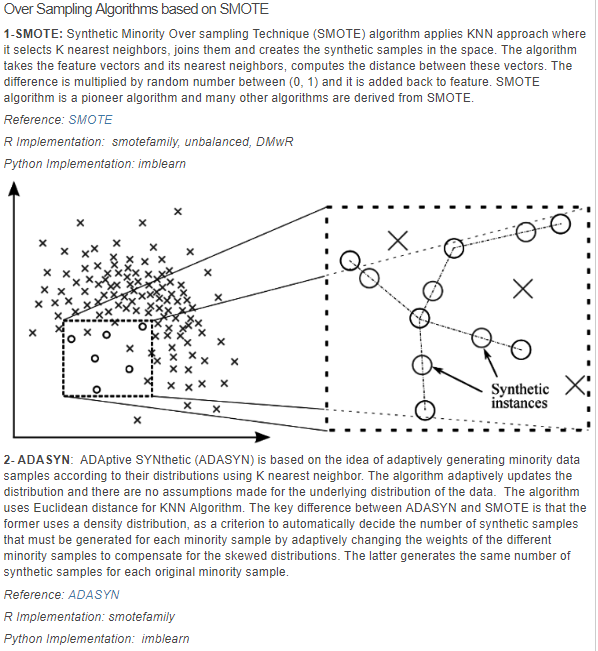



For more details, refer to the article on [*handling imbalanced data sets in supervised learning*](https://www.datasciencecentral.com/profiles/blogs/handling-imbalanced-data-sets-in-supervised-learning-using-family)

We we'll go with ADASYN over SMOTE as SMOTE will introduce some more noise into dataset comparing to ADASYN

In [75]:
X = data
Y = churn

#smote = SMOTE(random_state=RANDOM_STATE, ratio=1.0)
#X, Y = smote.fit_sample(X, Y)

adasyn = ADASYN(random_state=RANDOM_STATE)
X, Y = adasyn.fit_sample(X, Y)

print('Class Balance count : ',Counter(Y))


Class Balance count :  Counter({1: 90386, 0: 89808})


Note that the class is well balanced now. We can now split the train and test dataset.

# Split into train test 

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(126135, 225) (126135,)
(54059, 225) (54059,)


# PCA

Let's apply PCA on the training dataset for dimensionality reduction and feature selection.

In [77]:
#initialize the pca with randomized
pca = PCA(svd_solver='randomized', random_state=RANDOM_STATE)
# fit the training dataset
pca.fit(X_train)

PCA(random_state=42, svd_solver='randomized')

Draw the **screeplot** for the PCA components and pick the right number of PC components to build the model

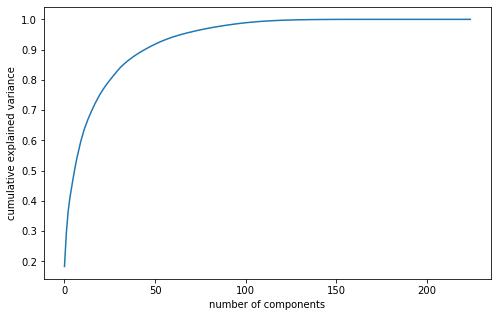

In [78]:
#Screeplot for the PCA components
%matplotlib inline
fig = plt.figure(figsize = (8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Chosen 50 PCA components for model building

In [79]:
# Initialize pca with 50 components
pca = PCA(n_components=50, random_state=RANDOM_STATE)
# fit and transform the training dataset
X_train_pca = pca.fit_transform(X_train)
# transform the testing dataset
X_test_pca = pca.transform(X_test)
# fit and transform the whole dataset
X_pca = pca.fit_transform(X)

# Baseline Model Building

In [80]:
# List to store the model scores
model_score_list = []

In [81]:
'''
Method Name : evaluate_model
Input(s)    : 2 series
Output(s)   : 4 float values  
Description :
- This method gets 2 series (actual and predicted) as inputs and compute the accuracy, ROC, Precision and Recall scores  
- Then returns the computed scores. 
'''
def evaluate_model(actual, pred):
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred)*100,2)
    print('Accuracy Score : ',acc_score)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    print('ROC AUC score : ',roc_score)
    # Precision score
    prec_score = round(precision_score(actual, pred)*100,2)
    print('Precision score : ', prec_score)
    # Recall score
    rec_score = round(recall_score(actual, pred)*100,2)
    print('Recall score : ', rec_score)

    return acc_score, roc_score, prec_score, rec_score

### Logistic Regression

In [82]:
# Initialize the Logistic regression
model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the testing pca data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list 
model_score_list.append({'model_name':'LogisticRegression', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  79.62
ROC AUC score :  79.64
Precision score :  81.09
Recall score :  77.67


### KNN

In [83]:
# initialize the KNeighbors classifiers
model = KNeighborsClassifier()
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'KNeighborsClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  89.11
ROC AUC score :  89.03
Precision score :  82.25
Recall score :  99.96


### SVC

In [84]:
# initialize the SVC rbf kernel
model = SVC(kernel='rbf', class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'SVC_Kernel_rbf', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  87.41
ROC AUC score :  87.39
Precision score :  85.77
Recall score :  89.93


### RandomForest

In [85]:
# initialize the randomforest
model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'RandomForestClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  95.27
ROC AUC score :  95.26
Precision score :  93.96
Recall score :  96.83


In [189]:
# Predict the model with the pca testing dataset
Y_pred = model.predict(X_test_pca)

# get the predict probablities of pca testing dataset
Y_pred_proba = model.predict_proba(X_test_pca)

In [224]:
feature_imp_df = pd.DataFrame({'Feature':X_train_pca.columns, 'Score':model.feature_importances_})
# Order the features by max score
feature_imp_df = feature_imp_df.sort_values('Score', ascending=False).reset_index()
feature_imp_df.head(50)

,index,Feature,Score
0,2,2,0.067852
1,6,6,0.057981
2,1,1,0.049141
3,0,0,0.038767
4,3,3,0.034121
5,5,5,0.032885
6,21,21,0.025769
7,20,20,0.025241
8,18,18,0.023791
9,27,27,0.022988


,index,Feature,Score
0,2,2,0.067852
1,6,6,0.057981
2,1,1,0.049141
3,0,0,0.038767
4,3,3,0.034121
5,5,5,0.032885
6,21,21,0.025769
7,20,20,0.025241
8,18,18,0.023791
9,27,27,0.022988


In [89]:
# plot the chart with top 50 important features
a = pd.Series(model.feature_importances_)
a

0     0.038767
1     0.049141
2     0.067852
3     0.034121
4     0.018519
5     0.032885
6     0.057981
7     0.014531
8     0.013494
9     0.013967
10    0.018114
11    0.022359
12    0.013586
13    0.017862
14    0.018098
15    0.013338
16    0.021218
17    0.015893
18    0.023791
19    0.022098
20    0.025241
21    0.025769
22    0.014633
23    0.013009
24    0.019601
25    0.013666
26    0.012909
27    0.022988
28    0.013137
29    0.013194
30    0.013111
31    0.015861
32    0.012044
33    0.014068
34    0.014838
35    0.014054
36    0.015360
37    0.020338
38    0.013689
39    0.017400
40    0.014555
41    0.014907
42    0.013821
43    0.011630
44    0.012969
45    0.014380
46    0.013282
47    0.015567
48    0.019451
49    0.016916
dtype: float64

In [90]:
i=1
for i in range(49):
    print(a.iat(i,2))
    
    break

    feature_imp_df['Feature Name'] = data.columns[x]


TypeError: '_iAtIndexer' object is not callable

In [91]:
importances = model.feature_importances_
print(importances)

[0.03876684 0.04914066 0.06785175 0.03412059 0.01851869 0.03288482
 0.05798096 0.01453127 0.01349374 0.01396735 0.01811371 0.02235891
 0.01358579 0.01786204 0.01809834 0.01333752 0.0212183  0.01589274
 0.02379117 0.02209751 0.02524053 0.02576872 0.01463324 0.01300874
 0.01960092 0.01366565 0.01290862 0.02298799 0.01313703 0.0131942
 0.01311055 0.01586103 0.01204363 0.01406806 0.0148384  0.01405416
 0.01536045 0.02033761 0.01368913 0.01740005 0.01455459 0.01490708
 0.01382078 0.01163024 0.01296949 0.01437979 0.01328207 0.01556691
 0.01945146 0.01691618]


In [92]:
indices = np.argsort(importances)[::-1]
indices

array([ 2,  6,  1,  0,  3,  5, 21, 20, 18, 27, 11, 19, 16, 37, 24, 48,  4,
       10, 14, 13, 39, 49, 17, 31, 47, 36, 41, 34, 22, 40,  7, 45, 33, 35,
        9, 42, 38, 25, 12,  8, 15, 46, 29, 28, 30, 23, 44, 26, 32, 43],
      dtype=int64)

In [93]:
indices=list(indices)
print(indices)

[2, 6, 1, 0, 3, 5, 21, 20, 18, 27, 11, 19, 16, 37, 24, 48, 4, 10, 14, 13, 39, 49, 17, 31, 47, 36, 41, 34, 22, 40, 7, 45, 33, 35, 9, 42, 38, 25, 12, 8, 15, 46, 29, 28, 30, 23, 44, 26, 32, 43]


In [102]:
names =[data.columns[i] for i in indices[:5]]
names

['arpu_8', 'offnet_mou_6', 'arpu_7', 'arpu_6', 'onnet_mou_6']

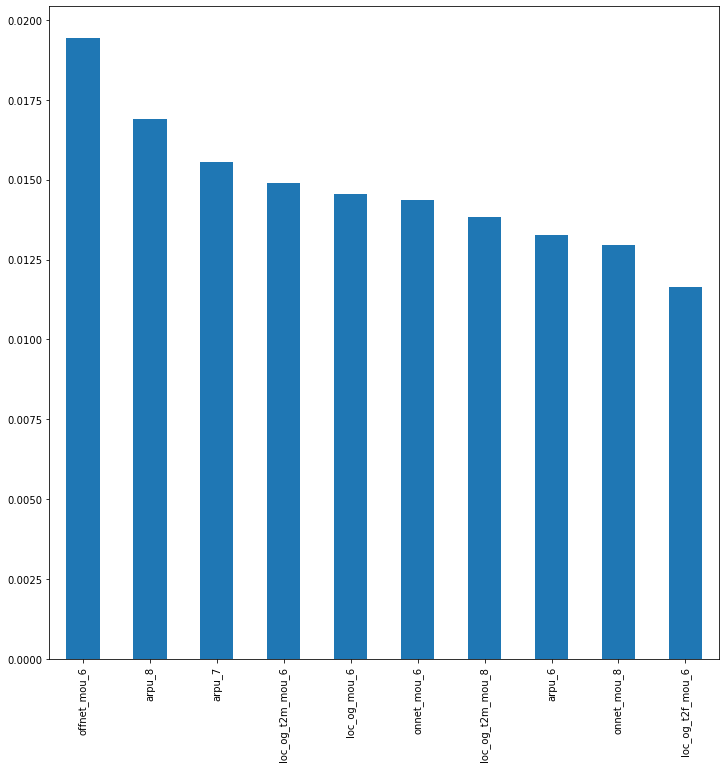

In [100]:
# plot the chart with top 5 important features
(pd.Series(importances[:-11:-1], index=names)
   .nlargest(10)
   .plot(kind='bar', figsize=(12,12))) 

In [101]:
feature_imp_df = pd.DataFrame({'Feature':X_train_pca.columns, 'Score':importances})
# Order the features by max score
feature_imp_df = feature_imp_df.sort_values('Score', ascending=False).reset_index()
feature_imp_df.head(50)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [187]:
feature_imp_df["Feature"]=[data.columns[i] for i in feature_imp_df["index"] and feature_imp_df["index"]!=21]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

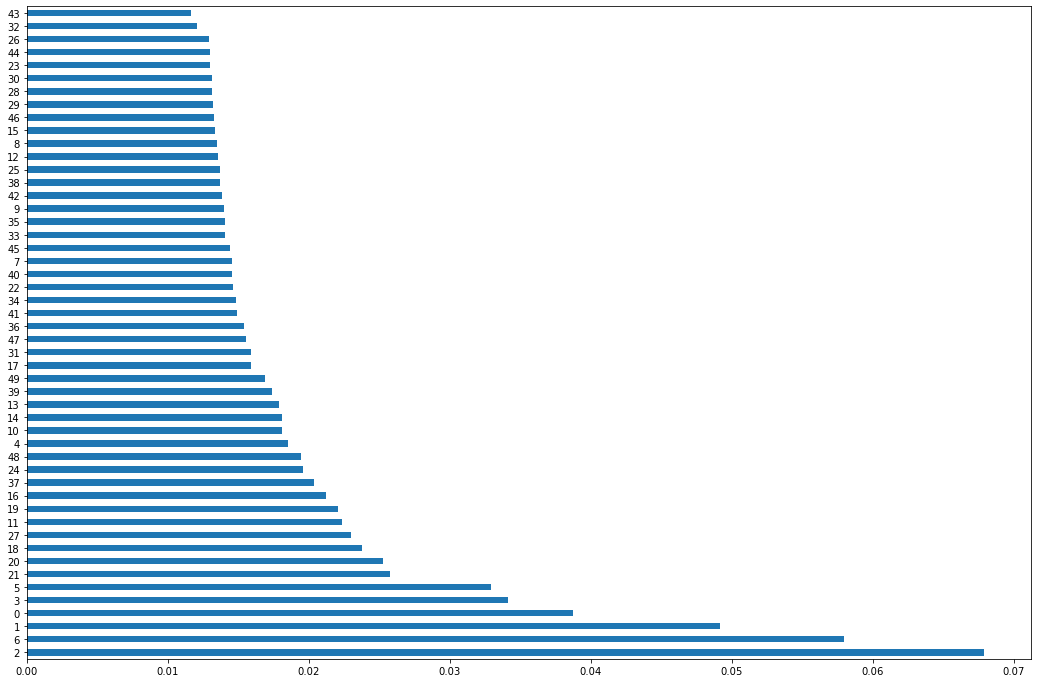

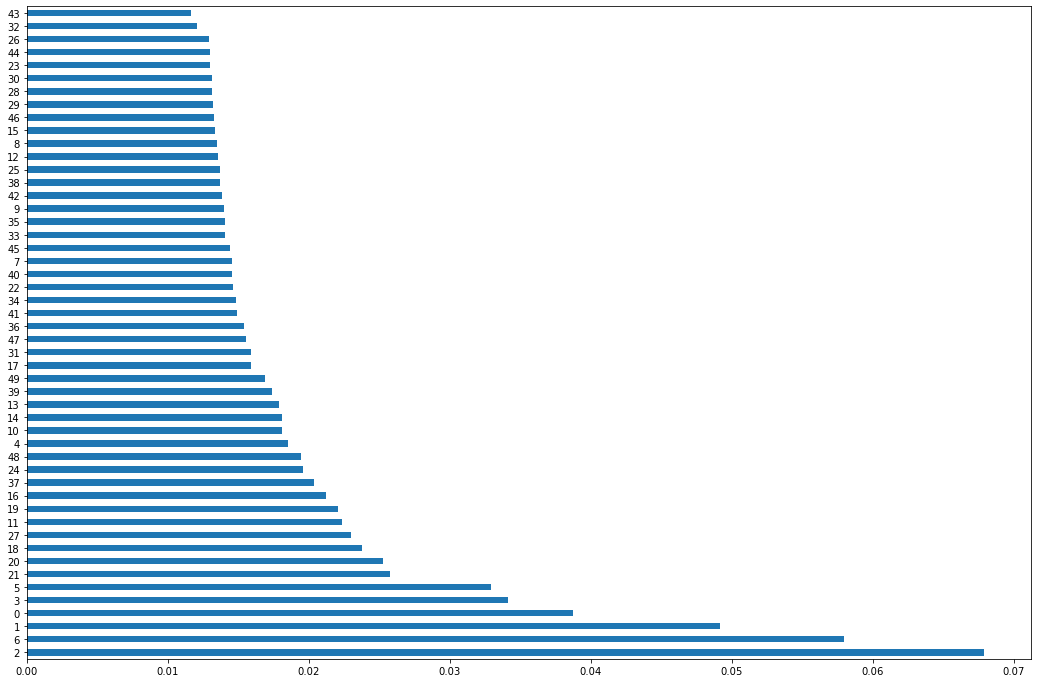

In [175]:
# plot the chart with top 50 important features
(pd.Series(model.feature_importances_, index=X_train_pca.columns)
   .nlargest(50)
   .plot(kind='barh', figsize=(18,12))) 

### XGBoosting

In [84]:
# Initialize the XGBoost
model = XGBClassifier(random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'XGBClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  89.78
ROC AUC score :  89.77
Precision score :  88.22
Recall score :  92.01


### Model score list

Let's view the models score list to select the top models

In [85]:
# convert the model scores to dataframe
model_score_df = pd.DataFrame(model_score_list,columns=['model_name', 'acc_score', 'roc_score','precision_score','recall_score'])

# Order by highest recall score and roc_auc_score
model_score_df.sort_values(['recall_score','roc_score'], ascending=False)

,model_name,acc_score,roc_score,precision_score,recall_score
1,KNeighborsClassifier,89.11,89.03,82.25,99.96
3,RandomForestClassifier,95.27,95.26,93.96,96.83
4,XGBClassifier,89.78,89.77,88.22,92.01
2,SVC_Kernel_rbf,87.41,87.39,85.78,89.93
0,LogisticRegression,79.62,79.64,81.09,77.67




##### KNeighborsClassifier
- Variation between recall_score and precision_score seem to be high at about 17%.
- But recall_score is almost 100% and the roc_auc_score is bit low at 89% comparing to other top two classifiers



# Cross Validation and Model Selection

Now we will do the cross validation for the top  models and select a model based on the mean score

In [86]:
# initialize Stratified KFold with 5 splits
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = RANDOM_STATE)

# Cross validation for KNeighborsClassifier
model = KNeighborsClassifier()
knn_cv_scores = cross_val_score(model, X_pca, Y, scoring='recall', cv = skf, n_jobs=-1)
print('KNeighborsClassifier cv_score_mean : ', round(knn_cv_scores.mean() * 100, 2))
print('KNeighborsClassifier cv_score_std : ', round(knn_cv_scores.std() * 100, 2))





KNeighborsClassifier cv_score_mean :  99.95
KNeighborsClassifier cv_score_std :  0.02
KNeighborsClassifier cv_score_mean :  99.95
KNeighborsClassifier cv_score_std :  0.02


### Plot the cv scores for the above 2 models

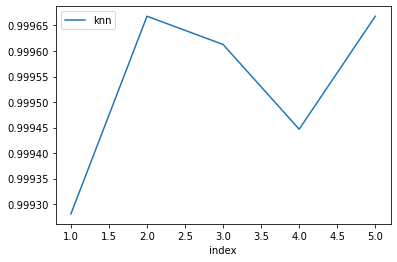

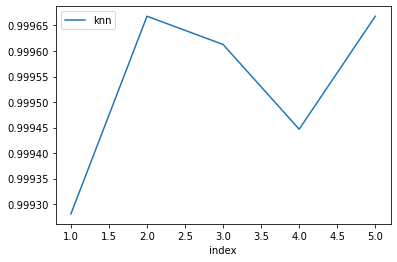

In [110]:
# plot the cv scores for the above 2 models
cv_scores_df = pd.DataFrame({'index':np.linspace(1,n_splits,n_splits),'knn':knn_cv_scores})
cv_scores_df.plot.line(x='index', y=['knn'])


In [115]:
# initialize the model with the best estimor
model = grid.best_estimator_

# fit the pca training dataset
model.fit(X_train_pca, Y_train)

# Predict the model with the pca testing dataset
Y_pred = model.predict(X_test_pca)

# get the predict probablities of pca testing dataset
Y_pred_proba = model.predict_proba(X_test_pca)

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
importances = model.feature_importances_
print(importances)

In [ ]:
indices = np.argsort(importances)[::-1]

In [ ]:
names = [data.columns[i] for i in indices in range(10)]
names

In [ ]:
plt.bar(range(data.shape[1]), importances[indices])
plt.xticks(range(data.shape[1]) ,names, rotation = 60)
plt.show()